In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.7 MB/s eta 0:00:00


In [2]:
from catboost import datasets
from sklearn.model_selection import train_test_split
from sklearn import  tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import  ensemble
import pandas as pd
import numpy as np
import catboost as cb


In [3]:

train_df, testk_df = datasets.amazon() 
train_df.shape, testk_df.shape

((32769, 10), (58921, 10))

In [4]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [5]:
train_df.ACTION.value_counts(normalize=True)

1    0.94211
0    0.05789
Name: ACTION, dtype: float64

In [ ]:
targetCol = "ACTION"

featuresCols = train_df.drop(columns=targetCol).columns.tolist()

y_train = train_df[targetCol]
X_train = train_df[featuresCols]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=y_train)

In [ ]:

clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=20)

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

<Axes: >

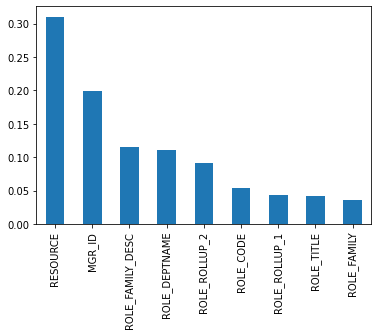

In [ ]:
pd.Series(clf.feature_importances_,featuresCols).sort_values(ascending=False).plot(kind="bar")

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 176  298]
 [ 244 7475]]
              precision    recall  f1-score   support

           0       0.42      0.37      0.39       474
           1       0.96      0.97      0.97      7719

    accuracy                           0.93      8193
   macro avg       0.69      0.67      0.68      8193
weighted avg       0.93      0.93      0.93      8193



In [ ]:
rf = ensemble.RandomForestClassifier(max_depth=20)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 151  323]
 [  69 7650]]
              precision    recall  f1-score   support

           0       0.69      0.32      0.44       474
           1       0.96      0.99      0.98      7719

    accuracy                           0.95      8193
   macro avg       0.82      0.65      0.71      8193
weighted avg       0.94      0.95      0.94      8193



<Axes: >

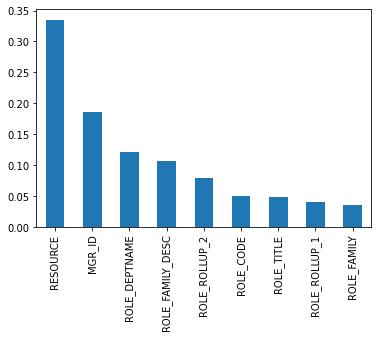

In [ ]:
pd.Series(rf.feature_importances_,featuresCols).sort_values(ascending=False).plot(kind="bar")

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)


[18:09:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [ ]:
y_pred = bst.predict(dtest)

In [ ]:
best_preds = np.asarray([np.argmax(line) for line in y_pred])


In [ ]:

print(confusion_matrix(y_test, best_preds))
print(classification_report(y_test, best_preds))

[[   1  473]
 [   0 7719]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       474
           1       0.94      1.00      0.97      7719

    accuracy                           0.94      8193
   macro avg       0.97      0.50      0.49      8193
weighted avg       0.95      0.94      0.91      8193



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

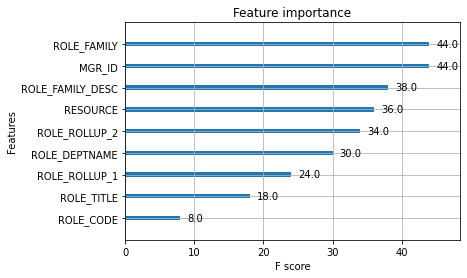

In [ ]:
#pd.DataFrame(bst.get_fscore().items(), columns=['feature','importance']).set_index("feature").sort_values('importance', ascending=False).plot(kind="bar")
xgb.plot_importance(bst)


In [ ]:
categorical_indices = range(len(X_train.columns))
train_dataset = cb.Pool(X_train,y_train, cat_features=categorical_indices)
test_dataset = cb.Pool(X_test,y_test, cat_features=categorical_indices)

In [ ]:
model = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy')
grid = {'learning_rate': [0.03, 0.1],
'depth': [4, 6, 10],
'l2_leaf_reg': [1, 3, 5,],
'iterations': [50, 100, 150]}
model.grid_search(grid,train_dataset)

Streaming output truncated to the last 5000 lines.
21:	learn: 0.9413021	test: 0.9452807	best: 0.9452807 (0)	total: 388ms	remaining: 2.25s
22:	learn: 0.9415056	test: 0.9452807	best: 0.9452807 (0)	total: 399ms	remaining: 2.2s
23:	learn: 0.9420651	test: 0.9454841	best: 0.9454841 (23)	total: 413ms	remaining: 2.17s
24:	learn: 0.9421160	test: 0.9456876	best: 0.9456876 (24)	total: 424ms	remaining: 2.12s
25:	learn: 0.9422177	test: 0.9462978	best: 0.9462978 (25)	total: 437ms	remaining: 2.08s
26:	learn: 0.9422686	test: 0.9465012	best: 0.9465012 (26)	total: 449ms	remaining: 2.04s
27:	learn: 0.9422177	test: 0.9465012	best: 0.9465012 (26)	total: 460ms	remaining: 2s
28:	learn: 0.9422177	test: 0.9462978	best: 0.9465012 (26)	total: 473ms	remaining: 1.97s
29:	learn: 0.9423703	test: 0.9460944	best: 0.9465012 (26)	total: 482ms	remaining: 1.93s
30:	learn: 0.9423703	test: 0.9460944	best: 0.9465012 (26)	total: 500ms	remaining: 1.92s
31:	learn: 0.9425738	test: 0.9460944	best: 0.9465012 (26)	total: 512ms	rema

{'params': {'depth': 10,
  'l2_leaf_reg': 3,
  'iterations': 150,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [ ]:
pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.64      0.19      0.29       474
           1       0.95      0.99      0.97      7719

    accuracy                           0.95      8193
   macro avg       0.80      0.59      0.63      8193
weighted avg       0.93      0.95      0.93      8193



In [ ]:
!pip install --pre pycaret


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.1/480.1 KB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 45.5 MB/s eta 0:00:00
 

In [ ]:
import pycaret
from pycaret.datasets import get_data
from pycaret.classification import *
import pandas as pd

In [ ]:
from sklearn.metrics import log_loss

clf = setup(train_df,target = targetCol,imputation_type='simple',fold = 3,train_size=0.7 )
# check all metrics used for model evaluation
get_metrics()
# add Log Loss metric in pycaret
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False)
# compare baseline models
best = compare_models()

,Description,Value
0,Session id,8512
1,Target,ACTION
2,Target type,Binary
3,Original data shape,"(32769, 10)"
4,Transformed data shape,"(32769, 10)"
5,Transformed train set shape,"(22938, 10)"
6,Transformed test set shape,"(9831, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
rf,Random Forest Classifier,0.9483,0.8220,0.9873,0.9590,0.9729,0.3871,0.4101,1.8652,1.8100
lightgbm,Light Gradient Boosting Machine,0.9466,0.8073,0.9970,0.9488,0.9723,0.1994,0.2862,1.9265,0.6667
catboost,CatBoost Classifier,0.9456,0.7919,0.9967,0.9482,0.9718,0.1814,0.2651,1.9610,5.8700
xgboost,Extreme Gradient Boosting,0.9455,0.8089,0.9926,0.9516,0.9717,0.2548,0.3061,1.9658,1.0867
et,Extra Trees Classifier,0.9441,0.7762,0.9807,0.9608,0.9706,0.3918,0.4011,2.0145,1.1567
lr,Logistic Regression,0.9421,0.5152,1.0000,0.9421,0.9702,0.0000,0.0000,2.0868,1.1067
ridge,Ridge Classifier,0.9421,0.0000,1.0000,0.9421,0.9702,0.0000,0.0000,2.0868,0.0500
gbc,Gradient Boosting Classifier,0.9421,0.7474,0.9991,0.9428,0.9701,0.0246,0.0776,2.0883,1.9600
lda,Linear Discriminant Analysis,0.9421,0.5155,1.0000,0.9421,0.9702,0.0000,0.0000,2.0868,0.0667
dummy,Dummy Classifier,0.9421,0.5000,1.0000,0.9421,0.9702,0.0000,0.0000,2.0868,0.0433


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…